In [1]:
import numpy as np
import os

DATA_PATH = 'Anuran_Calls_(MFCCs)'

In [2]:
import pandas as pd

def load_csv(path = DATA_PATH):
    csv_path = os.path.join(path, 'Frogs_MFCCs.csv')
    return pd.read_csv(csv_path)

In [3]:
df = load_csv()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
Family      7195 non-null object
Genus       7195 non-null object
Species     7195 non-null object
RecordID    7195 non-null int64
dtypes: float6

In [5]:
# Number of instances by class
df.loc[:,'Family'].value_counts()

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

In [6]:
df.loc[:,'Genus'].value_counts()

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

In [7]:
df.loc[:,'Species'].value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

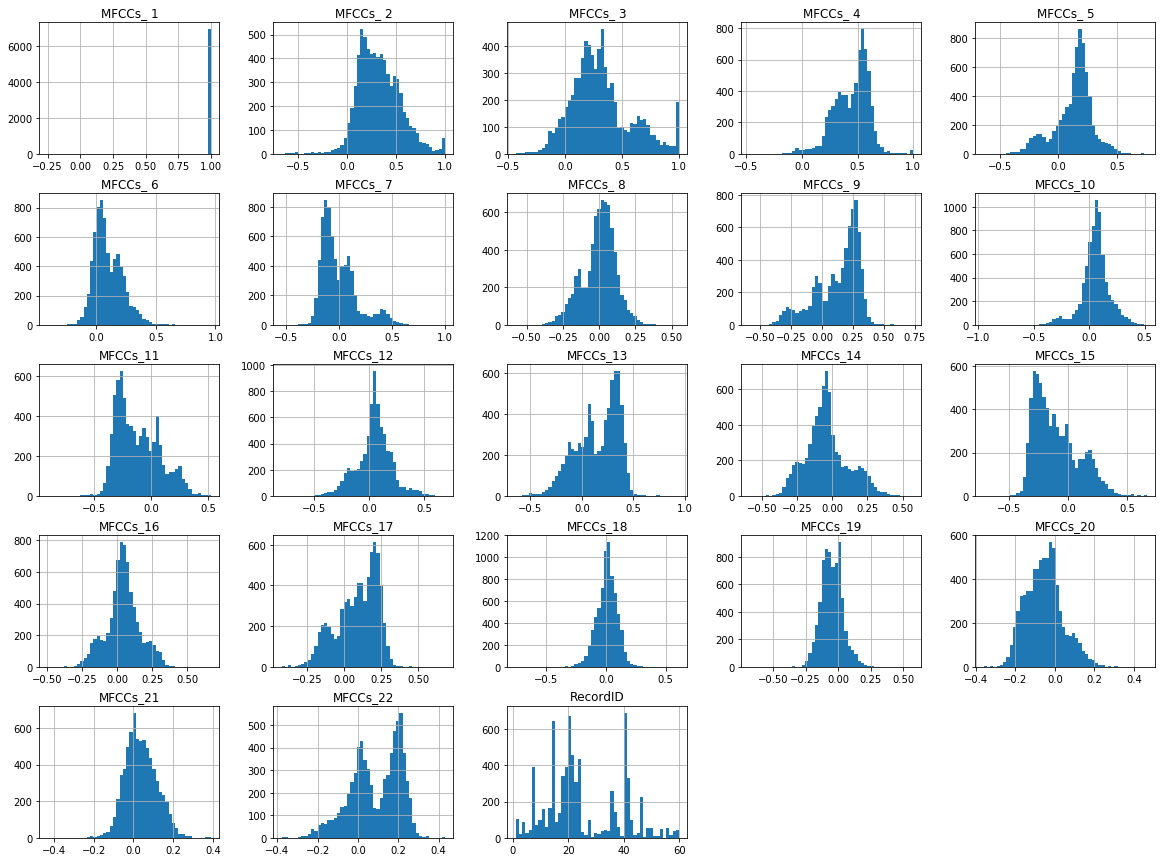

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# Right now only choosing species
X, Y = df.loc[:,'MFCCs_ 1':'MFCCs_22'], df.loc[:, 'Species']

In [9]:
from imblearn.under_sampling import RandomUnderSampler

dict = {
    'AdenomeraHylaedactylus': 1121
}

rus = RandomUnderSampler(ratio=dict)
X_resampled, Y_resampled = rus.fit_sample(X, Y)

print(str(X_resampled.size))
print(str(Y_resampled.size))

print(str(X.size))
print(str(Y.size))

print(pd.value_counts(Y_resampled))

106436
4838
158290
7195
AdenomeraHylaedactylus    1121
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
dtype: int64


In [10]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def createOneHotEncoded(arg):
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(arg)
    
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded

In [176]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        #val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=1)
        #val_targ = self.validation_data[1]
        val_targ = np.argmax(self.validation_data[1], axis=1)
        
        _val_f1 = f1_score(val_targ, val_predict, average="weighted")
        _val_recall = recall_score(val_targ, val_predict, average="weighted")
        _val_precision = precision_score(val_targ, val_predict, average="weighted")
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        # print(" — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return

In [217]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def createModel():
    model = Sequential()

    model.add(Dense(units=32, activation='relu', input_dim=22))
    model.add(Dense(units=64, activation='relu'))
    
    model.add(Dense(units=10, activation='softmax')) #10 species
    
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    
    return model

In [216]:
from sklearn.metrics import classification_report

N_EPOCHS = 50
BATCH_SIZE = 32

metrics = []

def trainAndTestModel(model, x_train, y_train, x_val, y_val):
    
    # Create new callback class
    metrics.append(Metrics())
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=BATCH_SIZE, epochs=N_EPOCHS, verbose=1, callbacks=[metrics[-1]])
    
    pred = model.predict(x_val, batch_size=32, verbose=0)
    y_pred = np.argmax(pred, axis=1)
    
    report = classification_report(argmax(y_val, axis=1), y_pred)
    
    #TODO: see if we need this
    #report = pandas_classification_report(np.argmax(y_val, axis=1), y_pred)
    
    print(report)
    
    return history 

In [188]:
from sklearn.metrics import classification_report
from  sklearn.metrics import precision_recall_fscore_support

np.random.seed(0)

def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

In [218]:
from sklearn.model_selection import StratifiedKFold

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=5, shuffle=True)

historyList = []
#reportList = []

for index, (train_indices, val_indices) in enumerate(skf.split(X_resampled, Y_resampled)):
    
    # Generate batches from indices
    xtrain, xval = X_resampled[train_indices], X_resampled[val_indices]
    ytrain, yval = createOneHotEncoded(Y_resampled[train_indices]), createOneHotEncoded(Y_resampled[val_indices])
    
    # Clear model, and create it
    model = None
    model = createModel()
    
    history = trainAndTestModel(model, xtrain, ytrain, xval, yval)
    
    historyList.append(history)
    

Train on 3866 samples, validate on 972 samples
Epoch 1/50
3866/3866 [==============================] - 11s 3ms/step - loss: 2.2280 - acc: 0.2362 - val_loss: 2.1258 - val_acc: 0.3683
 — val_f1: 0.230074 — val_precision: 0.167803 — val_recall 0.368313
Epoch 2/50
 896/3866 [=====>........................] - ETA: 0s - loss: 2.1072 - acc: 0.3650

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3866/3866 [==============================] - 1s 311us/step - loss: 2.0403 - acc: 0.4139 - val_loss: 1.9610 - val_acc: 0.4280
 — val_f1: 0.275728 — val_precision: 0.204720 — val_recall 0.427984
Epoch 3/50
3866/3866 [==============================] - 1s 197us/step - loss: 1.8890 - acc: 0.4470 - val_loss: 1.8223 - val_acc: 0.4527
 — val_f1: 0.301683 — val_precision: 0.233945 — val_recall 0.452675
Epoch 4/50
3866/3866 [==============================] - 1s 200us/step - loss: 1.7515 - acc: 0.4565 - val_loss: 1.6810 - val_acc: 0.4578
 — val_f1: 0.308607 — val_precision: 0.243266 — val_recall 0.457819
Epoch 5/50
3866/3866 [==============================] - 1s 194us/step - loss: 1.6114 - acc: 0.4584 - val_loss: 1.5492 - val_acc: 0.4599
 — val_f1: 0.315958 — val_precision: 0.255281 — val_recall 0.459877
Epoch 6/50
3866/3866 [==============================] - 1s 335us/step - loss: 1.4911 - acc: 0.4651 - val_loss: 1.4430 - val_acc: 0.4774
 — val_f1: 0.355442 — val_precision: 0.412412 — val_recall 

3866/3866 [==============================] - 1s 165us/step - loss: 0.3354 - acc: 0.9095 - val_loss: 0.3374 - val_acc: 0.9115
 — val_f1: 0.902890 — val_precision: 0.897388 — val_recall 0.911523
Epoch 43/50
3866/3866 [==============================] - 1s 157us/step - loss: 0.3305 - acc: 0.9108 - val_loss: 0.3337 - val_acc: 0.9167
 — val_f1: 0.910187 — val_precision: 0.917986 — val_recall 0.916667
Epoch 44/50
3866/3866 [==============================] - 1s 158us/step - loss: 0.3266 - acc: 0.9131 - val_loss: 0.3288 - val_acc: 0.9115
 — val_f1: 0.902963 — val_precision: 0.897787 — val_recall 0.911523
Epoch 45/50
3866/3866 [==============================] - 1s 150us/step - loss: 0.3225 - acc: 0.9152 - val_loss: 0.3252 - val_acc: 0.9218
 — val_f1: 0.917006 — val_precision: 0.923241 — val_recall 0.921811
Epoch 46/50
3866/3866 [==============================] - 1s 169us/step - loss: 0.3184 - acc: 0.9149 - val_loss: 0.3232 - val_acc: 0.9208
 — val_f1: 0.914649 — val_precision: 0.922334 — val_rec

3868/3868 [==============================] - 1s 145us/step - loss: 0.5015 - acc: 0.8498 - val_loss: 0.5246 - val_acc: 0.8474
 — val_f1: 0.815615 — val_precision: 0.792308 — val_recall 0.847423
Epoch 30/50
3868/3868 [==============================] - 1s 145us/step - loss: 0.4887 - acc: 0.8547 - val_loss: 0.5112 - val_acc: 0.8464
 — val_f1: 0.815551 — val_precision: 0.822579 — val_recall 0.846392
Epoch 31/50
3868/3868 [==============================] - 1s 144us/step - loss: 0.4761 - acc: 0.8573 - val_loss: 0.4989 - val_acc: 0.8546
 — val_f1: 0.827948 — val_precision: 0.840399 — val_recall 0.854639
Epoch 32/50
3868/3868 [==============================] - 1s 213us/step - loss: 0.4645 - acc: 0.8674 - val_loss: 0.4897 - val_acc: 0.8557
 — val_f1: 0.829895 — val_precision: 0.845174 — val_recall 0.855670
Epoch 33/50
3868/3868 [==============================] - 1s 179us/step - loss: 0.4536 - acc: 0.8694 - val_loss: 0.4771 - val_acc: 0.8670
 — val_f1: 0.845772 — val_precision: 0.858076 — val_rec

3871/3871 [==============================] - 1s 149us/step - loss: 0.7980 - acc: 0.7443 - val_loss: 0.7723 - val_acc: 0.7497
 — val_f1: 0.695006 — val_precision: 0.674002 — val_recall 0.749741
Epoch 17/50
3871/3871 [==============================] - 1s 153us/step - loss: 0.7649 - acc: 0.7502 - val_loss: 0.7410 - val_acc: 0.7559
 — val_f1: 0.702544 — val_precision: 0.706991 — val_recall 0.755946
Epoch 18/50
3871/3871 [==============================] - 1s 148us/step - loss: 0.7350 - acc: 0.7598 - val_loss: 0.7143 - val_acc: 0.7508
 — val_f1: 0.701941 — val_precision: 0.710582 — val_recall 0.750776
Epoch 19/50
3871/3871 [==============================] - 1s 149us/step - loss: 0.7083 - acc: 0.7605 - val_loss: 0.6879 - val_acc: 0.7663
 — val_f1: 0.722154 — val_precision: 0.729133 — val_recall 0.766287
Epoch 20/50
3871/3871 [==============================] - 1s 195us/step - loss: 0.6836 - acc: 0.7688 - val_loss: 0.6632 - val_acc: 0.7787
 — val_f1: 0.739343 — val_precision: 0.737688 — val_rec

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 3873 samples, validate on 965 samples
Epoch 1/50
3873/3873 [==============================] - 7s 2ms/step - loss: 2.2049 - acc: 0.2445 - val_loss: 2.0946 - val_acc: 0.3979
 — val_f1: 0.288255 — val_precision: 0.274408 — val_recall 0.397927
Epoch 2/50
3873/3873 [==============================] - 1s 151us/step - loss: 2.0167 - acc: 0.3573 - val_loss: 1.9423 - val_acc: 0.3679
 — val_f1: 0.242177 — val_precision: 0.279622 — val_recall 0.367876
Epoch 3/50
3873/3873 [==============================] - 1s 189us/step - loss: 1.8803 - acc: 0.3728 - val_loss: 1.8194 - val_acc: 0.3710
 — val_f1: 0.241664 — val_precision: 0.195193 — val_recall 0.370984
Epoch 4/50
3873/3873 [==============================] - 1s 230us/step - loss: 1.7584 - acc: 0.4712 - val_loss: 1.6998 - val_acc: 0.5575
 — val_f1: 0.423805 — val_precision: 0.454170 — val_recall 0.557513
Epoch 5/50
3873/3873 [==============================] - 1s 153us/step - loss: 1.6327 - acc: 0.5716 - val_loss: 1.5728 - val_acc: 0.5762
 — 

3873/3873 [==============================] - 1s 148us/step - loss: 0.3993 - acc: 0.8885 - val_loss: 0.4186 - val_acc: 0.8808
 — val_f1: 0.867281 — val_precision: 0.869191 — val_recall 0.880829
Epoch 42/50
3873/3873 [==============================] - 1s 146us/step - loss: 0.3932 - acc: 0.8908 - val_loss: 0.4010 - val_acc: 0.8902
 — val_f1: 0.876466 — val_precision: 0.876379 — val_recall 0.890155
Epoch 43/50
3873/3873 [==============================] - 1s 188us/step - loss: 0.3856 - acc: 0.8934 - val_loss: 0.3946 - val_acc: 0.8933
 — val_f1: 0.883115 — val_precision: 0.881439 — val_recall 0.893264
Epoch 44/50
3873/3873 [==============================] - 1s 192us/step - loss: 0.3796 - acc: 0.8972 - val_loss: 0.3901 - val_acc: 0.8819
 — val_f1: 0.868154 — val_precision: 0.869858 — val_recall 0.881865
Epoch 45/50
3873/3873 [==============================] - 1s 190us/step - loss: 0.3735 - acc: 0.8983 - val_loss: 0.3840 - val_acc: 0.8839
 — val_f1: 0.869334 — val_precision: 0.870204 — val_rec

3874/3874 [==============================] - 1s 360us/step - loss: 0.4780 - acc: 0.8650 - val_loss: 0.4789 - val_acc: 0.8548
 — val_f1: 0.837090 — val_precision: 0.847954 — val_recall 0.854772
Epoch 29/50
3874/3874 [==============================] - 1s 157us/step - loss: 0.4656 - acc: 0.8712 - val_loss: 0.4571 - val_acc: 0.8838
 — val_f1: 0.869953 — val_precision: 0.872204 — val_recall 0.883817
Epoch 30/50
3874/3874 [==============================] - 1s 157us/step - loss: 0.4539 - acc: 0.8764 - val_loss: 0.4451 - val_acc: 0.8797
 — val_f1: 0.864535 — val_precision: 0.867780 — val_recall 0.879668
Epoch 31/50
3874/3874 [==============================] - 1s 162us/step - loss: 0.4424 - acc: 0.8784 - val_loss: 0.4347 - val_acc: 0.8859
 — val_f1: 0.871768 — val_precision: 0.874852 — val_recall 0.885892
Epoch 32/50
3874/3874 [==============================] - 1s 156us/step - loss: 0.4316 - acc: 0.8828 - val_loss: 0.4249 - val_acc: 0.8880
 — val_f1: 0.873427 — val_precision: 0.876393 — val_rec

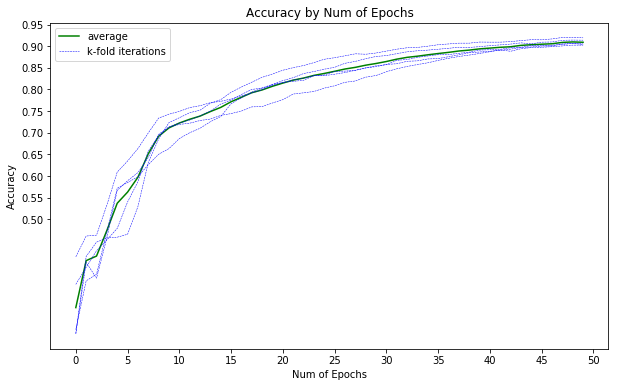

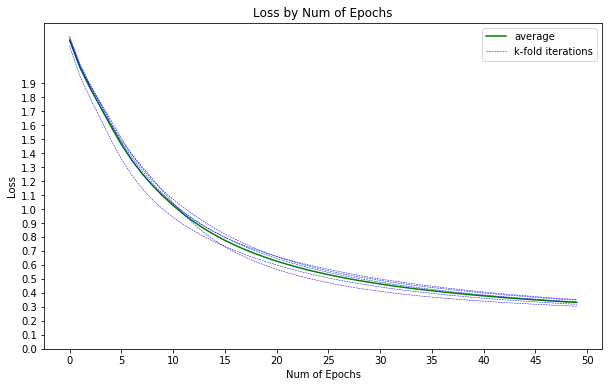

In [294]:
# idk why but it doesn't work inside the function
plt.rcParams['figure.figsize'] = (10, 6)

plotAccuracy(historyList)
plotLoss(historyList)


In [293]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotAccuracy(results):
    plt.figure(0)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['acc']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['acc'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, N_EPOCHS+5, 5.0))
    plt.yticks(np.arange(0.5, 1.0, 0.05))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by Num of Epochs")

    plt.show()
    
def plotLoss(results):
    plt.figure(1)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in results:
        sum += val.history['loss']
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in results:
        plt.plot(val.history['loss'], 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
        
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0, 2, 0.1))
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title("Loss by Num of Epochs")

    plt.show()
    

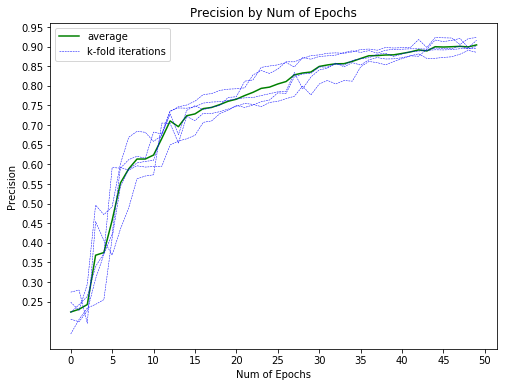

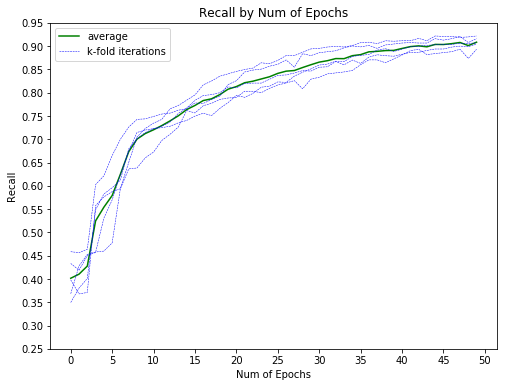

In [262]:
def plotPrecision(metrics):
    plt.figure(2)
    
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_precisions
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_precisions, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
       
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Precision")
    plt.title("Precision by Num of Epochs")
        
def plotRecall(metrics):
    plt.figure(3)
        
    sum = np.zeros(N_EPOCHS)
    
    for val in metrics:
        sum += val.val_recalls
         
    # Divide by number of folds
    average = sum / 5
    plt.plot(average, 'g')
    
    for val in metrics:
        plt.plot(val.val_recalls, 'b--', linewidth=0.5)
        
    plt.legend(['average', 'k-fold iterations'])
    
    plt.xticks(np.arange(0, 55, 5.0))
    plt.yticks(np.arange(0.25, 1, 0.05))
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Num of Epochs")
    plt.ylabel("Recall")
    plt.title("Recall by Num of Epochs")
    
plotPrecision(metrics)
plotRecall(metrics)
    
    

In [232]:
arr = np.array([1,2,3])
arr2 = np.array([1,2,3])

(arr+arr2)/2


array([1., 2., 3.])